The purpose of this notebook is to explore a mismatch between "durations" values which I calculate and those calculated from the pipeline. I expected that data queried from the GFDL-CM3 historical (1970) WRF precip data and summed over 4day periods should be equal to the data produced from the "durations" step in the pipeline, saved in `/workspace/Shared/Tech_Projects/DOT/project_data/durations/pcpt_4d_sum_wrf_GFDL-CM3_historical.nc`. This notebook exposes that mismatch. 

In [1]:
import os, time
import numpy as np
import pandas
import xarray as xr
from pyproj import Transformer
from matplotlib import pyplot as plt

# directories
data_dir = "/workspace/Shared/Tech_Projects/DOT/project_data"
wrf_dir = os.path.join(data_dir, "wrf_pcpt")
wrf_fp = os.path.join(wrf_dir, "pcpt", "pcpt_hourly_wrf_{}_{}_{}.nc")

# Point of Interest - WGS84 coordinates from example of invalid bounds
wgs84_coords = (-147.96, 64.66)
# WRF CRS
wrf_crs = '+units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=90.0 +x_0=0 +y_0=0 +a=6370000 +b=6370000'
transformer = Transformer.from_proj("EPSG:4326", wrf_crs, always_xy=True)
# WGS84 coordinates transformed to WRF CRS
wrf_coords = transformer.transform(*wgs84_coords)

# open durations file, query at POI
dur_ds = xr.open_dataset(os.path.join(wrf_dir, "durations", "pcpt_4d_sum_wrf_GFDL-CM3_historical.nc"))
dur_sel_da = dur_ds.sel(xc=wrf_coords[0], yc=wrf_coords[1], method="nearest")
pcpt_sum_dur = dur_sel_da.pcpt.values

# open raw WRF file, bin by 4d period and sum
raw_ds = xr.open_dataset(wrf_fp.format("GFDL-CM3", "historical", "1970"))
raw_sel = raw_ds.sel(xc=wrf_coords[0], yc=wrf_coords[1], method="nearest")
pcpt_sum_raw_da = raw_sel.resample(time="4D").sum()
pcpt_sum_raw = pcpt_sum_raw_da.pcpt.values

/home/UA/kmredilla/.localpython/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


time periods and coordinates match:

#### durations data:

In [2]:
print("time sample:", dur_sel_da.time.values[:5])
print("xc, yc:", dur_sel_da.xc.values, ",", dur_sel_da.yc.values)

time sample: ['1970-01-02T00:00:00.000000000' '1970-01-06T00:00:00.000000000'
 '1970-01-10T00:00:00.000000000' '1970-01-14T00:00:00.000000000'
 '1970-01-18T00:00:00.000000000']
xc, yc: 190000.0 , -2702425.477371664


#### calculated data:

In [3]:
print("time sample:", pcpt_sum_raw_da.time.values[:5])
print("xc, yc:", pcpt_sum_raw_da.xc.values, ",", pcpt_sum_raw_da.yc.values)

time sample: ['1970-01-02T00:00:00.000000000' '1970-01-06T00:00:00.000000000'
 '1970-01-10T00:00:00.000000000' '1970-01-14T00:00:00.000000000'
 '1970-01-18T00:00:00.000000000']
xc, yc: 190000.0 , -2702425.477371664


but these data don't match:

In [4]:
print("Sample of precip sums from pipeline:", pcpt_sum_dur[:5])
print("Sample of precip sums calculated from raw WRF:", pcpt_sum_raw[:5])

Sample of precip sums from pipeline: [ 3.782     12.1015     5.26      17.661499   0.9404998]
Sample of precip sums calculated from raw WRF: [ 3.278      7.8299994 10.0355     6.111     11.969    ]


test equivalence for a new location, same GCM and period:

In [5]:
# indices for new location
xc_idx, yc_idx = 100, 100

dur_sel_da = dur_ds.sel(xc=dur_ds.xc.values[xc_idx], yc=dur_ds.yc.values[yc_idx])
pcpt_sum_dur = dur_sel_da.pcpt.values

raw_sel = raw_ds.sel(xc=dur_ds.xc.values[xc_idx], yc=dur_ds.yc.values[yc_idx])
pcpt_sum_raw_da = raw_sel.resample(time="4D").sum()
pcpt_sum_raw = pcpt_sum_raw_da.pcpt.values

print("Sample of precip sums from pipeline:", np.round(pcpt_sum_dur[:5], 2))
print("Sample of precip sums calculated from raw WRF:", np.round(pcpt_sum_raw[:5], 2))

Sample of precip sums from pipeline: [15.73 29.4   1.34  0.47  0.62]
Sample of precip sums calculated from raw WRF: [8.640e+00 3.439e+01 3.430e+00 2.000e-02 5.700e-01]


test equivalence for 7d duration, same new location, same GCM and period:

In [6]:
xc_idx, yc_idx = 100, 100

# open durations file, query at POI
dur_ds = xr.open_dataset(os.path.join(wrf_dir, "durations", "pcpt_7d_sum_wrf_GFDL-CM3_historical.nc"))
dur_sel_da = dur_ds.sel(xc=dur_ds.xc.values[xc_idx], yc=dur_ds.yc.values[yc_idx])
pcpt_sum_dur = dur_sel_da.pcpt.values

# open raw WRF file, bin by 4d period and sum
raw_sel = raw_ds.sel(xc=dur_ds.xc.values[xc_idx], yc=dur_ds.yc.values[yc_idx])
pcpt_sum_raw_da = raw_sel.resample(time="7D").sum()
pcpt_sum_raw = pcpt_sum_raw_da.pcpt.values

print("Sample of precip sums from pipeline:", np.round(pcpt_sum_dur[:5], 2))
print("Sample of precip sums calculated from raw WRF:", np.round(pcpt_sum_raw[:5], 2))

Sample of precip sums from pipeline: [45.12  1.8   0.64  9.63  8.86]
Sample of precip sums calculated from raw WRF: [37.3   9.16  0.6   5.95 11.65]


test equivalence for 3h duration, new location, CCSM4 rcp85 2006:

In [7]:
# another location
xc_idx, yc_idx = 125, 125

# 3h duration file
dur_ds = xr.open_dataset(os.path.join(wrf_dir, "durations", "pcpt_3h_sum_wrf_NCAR-CCSM4_rcp85_2006.nc"))
dur_sel_da = dur_ds.sel(xc=dur_ds.xc.values[xc_idx], yc=dur_ds.yc.values[yc_idx])
pcpt_sum_dur = dur_sel_da.pcpt.values

# CCSM4 RCP85 data
raw_ds = xr.open_dataset(wrf_fp.format("NCAR-CCSM4", "rcp85", "2006"))
raw_sel = raw_ds.sel(xc=dur_ds.xc.values[xc_idx], yc=dur_ds.yc.values[yc_idx])
pcpt_sum_raw_da = raw_sel.resample(time="3H").sum()
pcpt_sum_raw = pcpt_sum_raw_da.pcpt.values

# find max index for showing sample
idx = pcpt_sum_dur.argmax()
print("Sample of precip sums from pipeline:", np.round(pcpt_sum_dur[idx:idx + 5], 2))
print("Sample of precip sums calculated from raw WRF:", np.round(pcpt_sum_raw[idx:idx + 5], 2))

Sample of precip sums from pipeline: [10.41  0.98  1.4   0.41  0.96]
Sample of precip sums calculated from raw WRF: [8.42 2.97 0.7  1.11 0.63]


### entire grid

Compute durations sums for the entire grid for 4d duration, GFDL-CM3 historical, and compare with manually computed values.

In [8]:
# open durations file, query at POI
dur_ds = xr.open_dataset(os.path.join(wrf_dir, "durations", "pcpt_4d_sum_wrf_GFDL-CM3_historical.nc"))
pcpt_sum_dur = dur_ds.pcpt.values

# open raw WRF file, bin by 4d period and sum
raw_ds = xr.open_dataset(wrf_fp.format("GFDL-CM3", "historical", "1970"))
pcpt_sum_raw_da = raw_ds.pcpt.resample(time="4D").sum()
pcpt_sum_raw = pcpt_sum_raw_da.values

OK, believe we should see matching 2d arrays for all time slices computable from the 1970 file. Verify firs that the time slices match:

In [9]:
print("First time slice of pipeline sums:", dur_ds.time.values[0])
print("First time slice of manually computed values:", pcpt_sum_raw_da.time.values[0])

First time slice of pipeline sums: 1970-01-02T00:00:00.000000000
First time slice of manually computed values: 1970-01-02T00:00:00.000000000


First times match. 

Now compare some individual time slices:

In [10]:
def plot_slices(ts,xy_sl=None):
    f, axarr = plt.subplots(1,2,figsize=(10,10))
    if xy_sl == None:
        axarr[0].imshow(pcpt_sum_dur[ts,:,:], interpolation="None")
        axarr[1].imshow(pcpt_sum_raw[ts,:,:], interpolation="None")
    else:
        axarr[0].imshow(pcpt_sum_dur[ts,xy_sl[3]:xy_sl[1],xy_sl[0]:xy_sl[2]], interpolation="None")
        axarr[1].imshow(pcpt_sum_raw[ts,xy_sl[3]:xy_sl[1],xy_sl[0]:xy_sl[2]], interpolation="None")

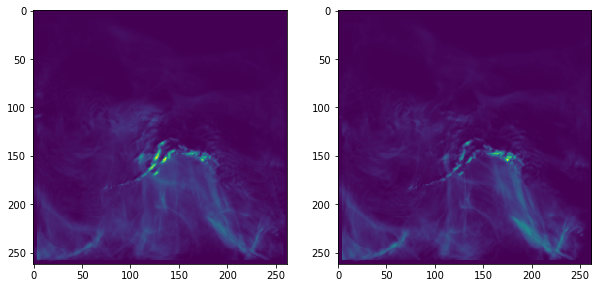

In [11]:
plot_slices(0)

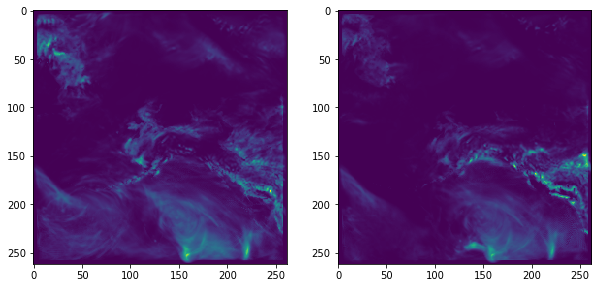

In [12]:
plot_slices(40)

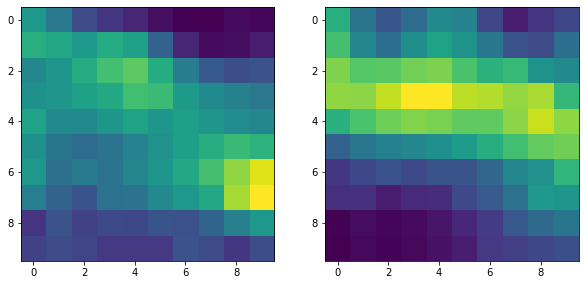

In [13]:
plot_slices(40, (150,160,160,150))

The results appear to be very similar, but not exaclty the same.